In [81]:
import numpy as np
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skimage import io, color, transform

import cv2
import numpy as np
import os
import pandas as pd
import re

from PIL import Image
from sklearn.preprocessing import MinMaxScaler

# READ DATA

In [82]:
#data_train = pd.read_csv("/Users/lethanhtien/Desktop/run/data/train.csv")
data = pd.read_csv("dataset.csv")

# CHECK CLASS IMBALANCE

In [83]:
class_counts = data['label'].value_counts()
print(class_counts)

label
1    1000
2    1000
3    1000
4    1000
0     999
Name: count, dtype: int64


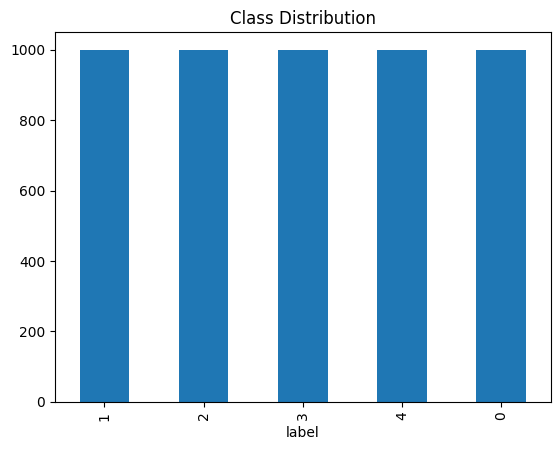

In [84]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ cân bằng lớp
class_counts.plot(kind='bar', title='Class Distribution')
plt.show()


In [85]:
total_samples = len(data)
class_ratios = class_counts / total_samples
print(class_ratios)


label
1    0.20004
2    0.20004
3    0.20004
4    0.20004
0    0.19984
Name: count, dtype: float64


# SPLIT DATA

In [86]:
# x_train = data_train.drop("label", axis=1)
# y_train = data_train['label']

# x_test = data_test.drop("label", axis=1)
# y_test = data_test['label']

x = data.drop("label", axis=1)
y = data['label']

In [87]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values

In [88]:
X_train[0]

array([ 28,  23,  24, ..., 166, 211, 218], dtype=int64)

# SCALE DATA

In [89]:
from sklearn.preprocessing import MinMaxScaler

In [90]:
# Khởi tạo mô hình MinMaxScaler và fit trên tập huấn luyện
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Sử dụng mô hình đã fit để chuẩn hóa tập kiểm tra
X_test_scaled = scaler.transform(X_test)

# TRAINING

In [91]:
from sklearn.svm import SVC
# Huấn luyện mô hình SVM với các tham số cụ thể
svm_model = SVC(C=0.1, gamma=0.1, kernel='linear', probability=True)
svm_model.fit(X_train_scaled, y_train)

# Dự đoán nhãn trên tập kiểm tra
y_pred = svm_model.predict(X_test_scaled)

# Đánh giá độ chính xác của mô hình
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.616


# EVALUATE

In [92]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Tính precision, recall, và f1-score cho từng lớp
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

class_names = [0,1,2,3,4]

# Đánh giá độ chính xác của mô hình
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}\n')

for i in range(len(class_names)):
    print(f"Class {class_names[i]}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-Score: {f1[i]:.4f}")
    print()


Accuracy: 0.616

Class 0:
  Precision: 0.5337
  Recall: 0.5236
  F1-Score: 0.5286

Class 1:
  Precision: 0.4947
  Recall: 0.4677
  F1-Score: 0.4808

Class 2:
  Precision: 0.8376
  Recall: 0.8128
  F1-Score: 0.8250

Class 3:
  Precision: 0.7835
  Recall: 0.8085
  F1-Score: 0.7958

Class 4:
  Precision: 0.4455
  Recall: 0.4796
  F1-Score: 0.4619



# TEST

In [93]:
def test(path):
    # Đường dẫn của tấm ảnh
    image_path = path

    # Mở ảnh bằng Pillow
    img = Image.open(image_path)

    # Chuyển ảnh về ảnh trắng đen
    img = img.convert("L")

    # Chuyển ảnh thành mảng NumPy
    img_array = np.array(img)

    # Resize ảnh về kích thước mong muốn
    resized_img = cv2.resize(img_array, (48, 48))

    flattened_img = resized_img.flatten().reshape(-1, 1)
    # Use MinMaxScaler
    scaler = MinMaxScaler()
    img1 = scaler.fit_transform(flattened_img).T

    y_pred = svm_model.predict(img1)

    return y_pred

In [94]:
test("data_img/fear/(fear) 298.jpg")

array([1], dtype=int64)

# SAVE MODEL

In [95]:
from joblib import dump
dump(svm_model, 'svm_model.h5')

['svm_model.h5']

# TRAINING

In [96]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
# Thiết lập các giá trị thử nghiệm cho C, kernel và gamma
param_grid = {'C': [0.1, 1, 10, 100],
              'kernel': ['linear', 'rbf'],
              'gamma': [0.1, 0.5, 1, 2, 5]}

# Tạo mô hình SVM
svm_model = SVC()

# Sử dụng GridSearchCV để tìm kiếm qua lưới tham số
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# In ra tham số tốt nhất
print("Best Parameters:", grid_search.best_params_)

# Đánh giá mô hình trên tập kiểm tra
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

KeyboardInterrupt: 

# GRADIO.APP INTERFACE


In [ ]:
%pip install --upgrade gradio

In [101]:
import gradio as gr
import numpy as np
from PIL import Image
from joblib import load
import dlib

svm_model = load('svm_model.h5')

emotion_labels = {
    0: "Angry",
    1: "Fear",
    2: "Happy",
    3: "Neutral",
    4: "Sad",
}

# Load dlib's pre-trained face detector
detector = dlib.get_frontal_face_detector()

def predict_emotion(image):
    # Convert Gradio Image to NumPy array
    img_array = np.array(image)

    # Convert to grayscale
    processed_image = Image.fromarray(img_array).convert('L').resize((48, 48))

    # Convert to NumPy array
    processed_image_array = np.array(processed_image)

    # Flatten and reshape
    flattened_img = processed_image_array.flatten().reshape(1, -1) / 255.0

    # Make prediction using SVM model
    prediction = svm_model.predict(flattened_img)[0]

    # Detect faces using dlib
    faces = detector(img_array, 1)
    
    if len(faces) == 0:
        cropped_face = img_array
    else:
        # Assuming there's only one face detected, you can modify this if needed
        x, y, w, h = faces[0].left(), faces[0].top(), faces[0].width(), faces[0].height()
        cropped_face = img_array[y:y+h, x:x+w]

    print("Input image shape:", img_array.shape)
    print("Processed image shape:", processed_image_array.shape)

    return emotion_labels[prediction], cropped_face


iface = gr.Interface(
    fn=predict_emotion,
    inputs="image",
    outputs=["text", "image"],  # Specify both text and image outputs
    live = True,
    title="Emotion Detection",
    description="Upload an image and predict the emotion."
)

iface.launch()


Running on local URL:  http://127.0.0.1:7892

To create a public link, set `share=True` in `launch()`.


Input image shape: (1673, 2234, 3)
Processed image shape: (48, 48)


Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gradio\queueing.py", line 495, in call_prediction
    output = await route_utils.call_process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gradio\route_utils.py", line 232, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gradio\blocks.py", line 1561, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\Loca